This presentation aims to price Asian and Lookback options with a Monte Carlo approach, by simulating the underlying stock price with an Euler-Maruyama scheme and calculating the expected value of the discounted payoff under the risk-neutral density $\mathbb{Q}$.

The objectives are:
- **Section I**: Simulate the underlying stock price and calculate the option value for each option type
- **Section II**: Vary the option and underlying stock parameters to see the effects on the option price
- **Section III**: Vary the parameters of the Monte Carlo scheme itself to see the effects on the option price and the robustness of the Monte Carlo pricing approach

In [1]:
# Importing libraries
import pandas as pd
from numpy import *
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from tabulate import tabulate
from datetime import datetime

# Plot settings
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = [20.0, 8.0]
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.linewidth'] = 2.0

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Definitions & Functions

## Simulation of the underlying stock price

An option price is the **expected** value of the discounted payoff under the risk-neutral density $\mathbb{Q}$. Therefore, prior estimating the option payoff, we must calculate the **expected** underlying stock price in some time forward in the future, more precisely from now until when the option time to maturity.

Under the risk-neutral density $\mathbb{Q}$, the underlying stock price is ruled by the following Stochastic Differential Equation

$$ \frac{dS_t}{S_t}=r\,dt+\sigma\,dW_t$$
The solution of this Stochastic Differential Equation is 
$$ S_{t+\delta t} = S_t \,exp \left\{(r-\frac{1}{2}\sigma^2)+ \sigma \phi \sqrt{\delta t}\right\}$$
**Note**: $\phi$ is sampled from a standard normal distribution.

Conducting a Taylor development of $\frac{S_{t+\delta t}}{S_t}$ in $O\,(\sqrt{\delta t})$ leads to the Euler Maruyama scheme:
$$S_{t+\delta t} \sim S_t \; (1 + r\delta t + \sigma \phi \sqrt{\delta t})$$

Multiple underlying asset paths are generated through the Euler-Maruyama method and averaged in order to derive the **expected** underlying value when the option arrives at maturity.

In [2]:
def simulate_path(s0, rate, volatility, expiry, timesteps, n_sims):
# Underlying stock path simulation under Euler-Maruyama scheme
# We use the rate r and not the drift mu to simulate the asset path as we are under the risk-neutral probability Q

    # Set the random seed for reproducibility of results
    random.seed(10)
    
    # Define dt: length of time interval
    dt = expiry/timesteps  
    
    # Simulating 'n_sims' asset price paths with 't' timesteps
    S = zeros((timesteps, n_sims))
    S[0] = S0

    for i in range(0, timesteps-1):
        w = random.standard_normal(n_sims)
        S[i+1] = S[i] * (1 + rate * dt + volatility * sqrt(dt) * w)
        
    return S

We now generate 100,000 underlying asset paths over the next 252 days with the Euler-Maruyama method, as illustrated in the table below.

In [3]:
# Generate underlying asset paths
S0 = 100; r = 0.05; volatility = 0.2; T = 1; t = 252; n = 100000
S = simulate_path(S0,r,volatility,T,t,n)
price_path = pd.DataFrame(S)
price_path.tail()

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
247,107.122461,89.677863,90.587542,90.590660,100.396865,79.147466,64.915237,96.941855,89.292641,92.777338,...,108.855864,75.891920,126.111373,104.129508,118.005326,107.442737,81.879664,136.383558,106.227976,137.608813
248,106.989602,91.281742,92.302986,90.012093,99.851880,77.241587,64.581987,98.930283,90.050460,91.280037,...,109.119975,76.884433,127.017397,107.133675,116.376964,105.365189,84.241406,137.598031,108.177597,139.909953
249,108.027475,91.182739,93.360650,90.772348,100.393333,77.246641,65.234111,98.927846,90.178937,90.030355,...,108.519738,76.747639,127.045763,108.753459,116.149732,105.012418,84.477443,137.034744,108.820110,142.913769
250,109.401147,89.810384,93.638937,90.006207,104.356103,76.440724,65.549847,99.135553,90.650068,89.676252,...,108.776202,77.008836,125.339835,110.248156,115.834940,108.115838,84.512517,135.910076,107.761444,144.144563
251,110.123434,89.309816,92.911144,89.206627,103.920154,75.724402,65.082349,99.595050,91.351337,90.129973,...,108.743633,77.220474,126.024937,110.003179,115.816542,108.037172,84.965216,136.074552,109.223134,144.278874


As we sampled our random variable $\phi$ from a standard normal distribution, we expect the underlying stock price to follow a log-normal distribution. Let's make sure it's the case before moving on.

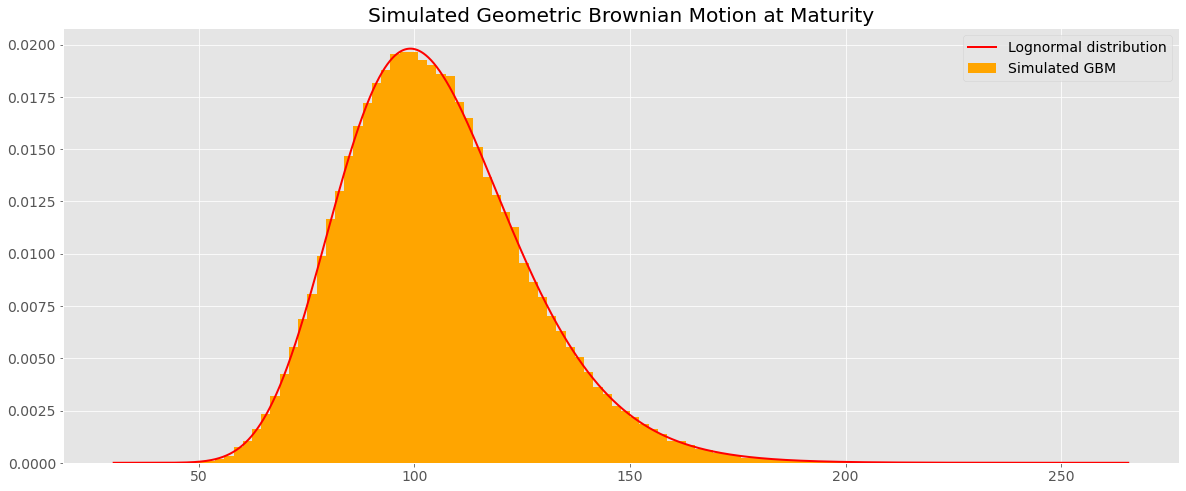

In [4]:
# Plot the histogram of the simulated price path at maturity
price_path.iloc[-1].hist(bins=100, color='orange', density=True, label='Simulated GBM')
plt.title('Simulated Geometric Brownian Motion at Maturity');

# Fitting a log normal distribution of the simulated GBM
xmin, xmax = plt.xlim()
x = linspace(xmin, xmax, len(price_path.iloc[-1]))
a, b, c = stats.lognorm.fit(price_path.iloc[-1])
lognorm = stats.lognorm.pdf(x,a,b,c)
plt.plot(x, lognorm, 'r', linewidth = 2, label = 'Lognormal distribution');
plt.legend()
plt.show()

We now have a distribution of 100,000 underlying stock prices over the next 252 days. We are now able to calculate what is the expected stock price in one year's time, and also the option payoff at maturity.

The below illustrates the Euler-Maruyama method in practice. Here, the first 100 simulated underlying stock prices are represented. We take the average of all paths to determine the overall underlying stock price at expiration in order to calculate the option payoff.

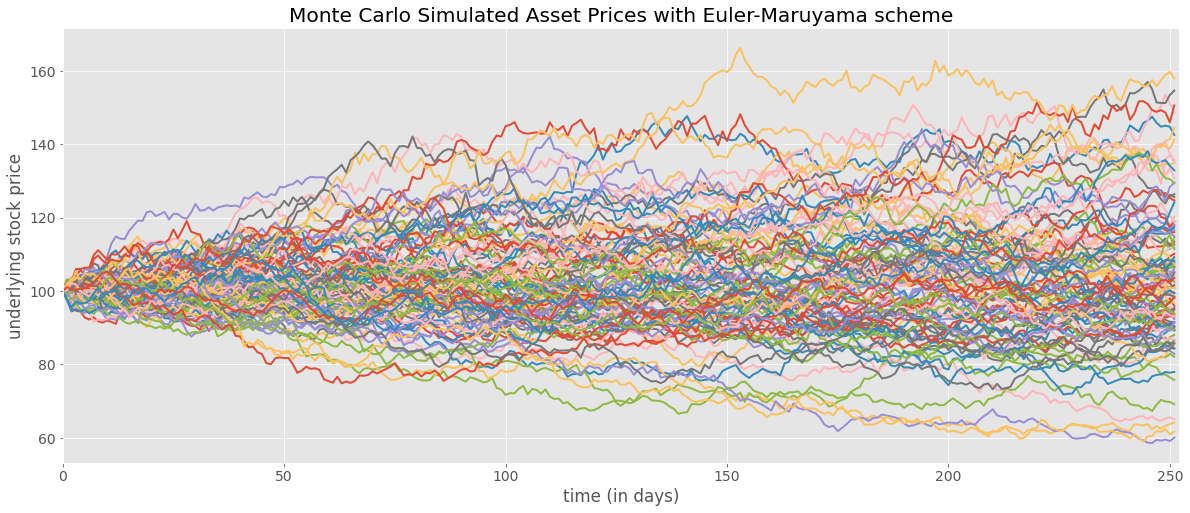

In [5]:
# Plot initial 100 simulated path using matplotlib
plt.plot(price_path.iloc[:,:100])
plt.xlabel('time (in days)')
plt.xlim(0,252)
plt.ylabel('underlying stock price')
plt.title('Monte Carlo Simulated Asset Prices with Euler-Maruyama scheme');

Unlike European, American or Bermudan options, which have their payoffs only depending on the price of the underlying stock at the time of exercise, **Asian and lookback options are said to be strong path-dependent exotic options**. Strong path dependence is said for options whose payoff does not only depend on the value of the underlying at maturity, but also on some property of the underlying during the life of the option. The value of a strong path-dependent option will be a function of the underlying stock price at maturity, time, as well as a new variable **I** that keeps track of the path-dependent information over the life of the option.

## Asian options

Asian options are strongly path-dependent as their payoffs depend on some average property of the underlying asset price over the life, or some part of the life of the option. Because of the averaging feature, Asian options reduce the volatility inherent in the option, as the uncertainty arising from underlying stock price variations is reduced. As volatility is the main driver of option pricing, we expect Asian options to be cheaper than their American or European counterparts.

The strike of an Asian option is formed by some aggregation of underlying asset prices during the option. There are two types of Asian options
- **Fixed strike**: averaging price is used in place of underlying price

$$ Call\;(T)= max\;(A_{(0,T)} - E, 0) \quad \quad Put\;(T)= max\;(E - A_{(0,T)}, 0) $$

- **Floating strike** (or fixed-price): averaging price is used in place of strike.

$$ Call\;(T)= max\;(S_T - A_{(0,T)}, 0) \quad \quad Put\;(T)= max\;(A_{(0,T)} - ST, 0)$$
With:

- $E$: strike of the Asian option
- $S_T$: underlying stock price at time $T$
- $A_{(0,T)}$: average of the underlying stock price between $0$ and $T$.

A couple of additional comments:
- Asian option payoffs can be computed by averaging the underlying stock price under continuous time (i.e. every day) or discrete time (i.e. use the underlying stock price the first day of the week or month)

- Asian options can use either the arithmetic average $$A_T=\frac{1}{T}\int_{O}^{T}S_t\;dt \;\text{(continuous)} \qquad A_T=\frac{1}{N} \sum_{i=1}^{N}S_{t_i} \; \text{(discrete)}$$ 

or the geometric average of the asset price (expressed here under continuous time assumption)$$A_T=exp \: (\frac{1}{T}\int_{O}^{T} log(S_t)\;dt\;\text{(continuous)}\qquad A_T=\left[\prod_{i=1}^{N}S_{t_i}\right]^{1/N} \; \text{(discrete)}$$

- Finally, Asian options can have American exercise (i.e. the option can be exercised at any time overt the life of the option) or European exercise (option exercise only possible at maturity). Unfortunately, one of the key weaknesses of the Monte Carlo simulation is that it doesn't cope well with embedded decisions, such as American-style early exercise features, as we will see in section III.

**Going forward, options refer to European-exercise style options - option exercise at maturity only**.

In [4]:
# Function to calculate the geometric average
def g_mean(x):
    a = log(x)
    return exp(a.mean(axis=0))

In [5]:
class Asian:
    
    """
    This is a class for pricing Asian call and puts options on stocks without dividends
        Options can be either with fixed or floating Strike ('Fix' or 'Float' in the option prefix)
        Options can be either with arithmetic or geometric average ('Arit' or 'Geom' in the option prefix)     
    
    Attributes: 
        spot          : int or float
        strike        : int or float 
        rate          : float
        dte           : int or float [in years]
        volatility    : float
        asset_path    : list or array
        
    """    
    
    def __init__(self, spot, strike, rate, expiry, volatility, asset_path):
        
        # Spot Price
        self.spot = spot
        # Option Strike
        self.strike = strike
        # Interest Rate
        self.rate = rate
        # Time To Maturity (in years)
        self.expiry = expiry
        # Volatility
        self.volatility = volatility
        # Monte Carlo Simulated underlying asset price S
        self.asset_path = asset_path
        
        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero') # raise an exception
        else:
            self._d1_ = ((log(self.spot/self.strike) + 0.5*(self.rate+self.volatility**2/6)*self.expiry)/(self.volatility * (self.expiry/3) ** 0.5))

        self._d2_ = self._d1_ - self.volatility * (self.expiry/3) ** 0.5        
        
        # __dict__ attribute

        for i in ['callGeomFixBSprice','putGeomFixBSprice','callGeomFixMCprice', 'putGeomFixMCprice', \
                 'callGeomFloatMCprice','putGeomFloatMCprice','callAritFixMCprice', 'putAritFixMCprice', \
                 'callAritFloatMCprice','putAritFloatMCprice']: 
            self.__dict__[i] = None
        
        [self.callGeomFixBSprice, self.putGeomFixBSprice] = self._GeomFixBSprice()
        [self.callGeomFixMCprice, self.putGeomFixMCprice] = self._GeomFixMCprice()
        [self.callGeomFloatMCprice, self.putGeomFloatMCprice] = self._GeomFloatMCprice()
        [self.callAritFixMCprice, self.putAritFixMCprice] = self._AritFixMCprice()
        [self.callAritFloatMCprice, self.putAritFloatMCprice] = self._AritFloatMCprice()       
    
    # Black Scholes Asian Option Price (confer Section III: Monte Carlo convergence)
    def _GeomFixBSprice(self): # Black-Scholes closed form solution for the geometric fixed asian option

        if self.volatility == 0 or self.expiry == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot *exp(-0.5*(self.rate + self.volatility**2/6)*self.expiry)*norm.cdf(self._d1_) - self.strike*exp(-self.rate*self.expiry)*norm.cdf(self._d2_)
            put = self.strike*exp(-self.rate*self.expiry)*norm.cdf(-self._d2_) - self.spot *exp(-0.5*(self.rate + self.volatility**2/6)*self.expiry)*norm.cdf(-self._d1_)
        return [call, put]
    
    # Option price with Monte Carlo simulation
    def _GeomFixMCprice(self): # Geometric Fixed Asian Option obtained with Monte Carlo method
        avg = g_mean(self.asset_path)
        call = exp(-self.rate*self.expiry) * mean(maximum(avg - self.strike, 0))
        put = exp(-self.rate*self.expiry) * mean(maximum(self.strike - avg, 0))
        return [call, put]
    
    def _GeomFloatMCprice(self): # Geometric Floating Asian Option obtained with Monte Carlo method
        avg = g_mean(self.asset_path)
        call = exp(-self.rate*self.expiry) * mean(maximum(self.asset_path[-1] - avg, 0))
        put = exp(-self.rate*self.expiry) * mean(maximum(avg - self.asset_path[-1], 0))
        return [call, put]
    
    def _AritFixMCprice(self): # Arithmetic Fixed Asian Option obtained with Monte Carlo method
        avg = (self.asset_path).mean(axis=0)
        call = exp(-self.rate*self.expiry) * mean(maximum(avg - self.strike, 0))
        put = exp(-self.rate*self.expiry) * mean(maximum(self.strike - avg, 0))
        return [call, put]

    def _AritFloatMCprice(self): # Arithmetic Floating Asian Option obtained with Monte Carlo method
        avg = (self.asset_path).mean(axis=0)
        call = exp(-self.rate*self.expiry) * mean(maximum(self.asset_path[-1] - avg, 0))
        put = exp(-self.rate*self.expiry) * mean(maximum(avg - self.asset_path[-1], 0))
        return [call, put]

In [6]:
# Getting Asian option prices
E = 100;S0 = 100; r = 0.05; sigma = 0.2; T = 1; t = 252; n = 100000
# Ouput results in tabular format
table = [['Asian Arithmetic Fixed Strike', Asian(S0,E,r,T,sigma,S).callAritFixMCprice, Asian(S0,E,r,T,sigma,S).putAritFixMCprice], \
         ['Asian Geometric Fixed Strike', Asian(S0,E,r,T,sigma,S).callGeomFixMCprice, Asian(S0,E,r,T,sigma,S).putGeomFixMCprice], \
         ['Asian Arithmetic Floating Strike', Asian(S0,E,r,T,sigma,S).callAritFloatMCprice, Asian(S0,E,r,T,sigma,S).putAritFloatMCprice], \
         ['Asian Geometric Floating Strike', Asian(S0,E,r,T,sigma,S).callGeomFloatMCprice, Asian(S0,E,r,T,sigma,S).putGeomFloatMCprice] ]
header = ['Option Type','Call Price', 'Put Price']
print(tabulate(table,headers=header))

Option Type                         Call Price    Put Price
--------------------------------  ------------  -----------
Asian Arithmetic Fixed Strike          5.75649      3.30766
Asian Geometric Fixed Strike           5.53884      3.42509
Asian Arithmetic Floating Strike       5.88179      3.36898
Asian Geometric Floating Strike        6.09164      3.24374


## Lookback options

Lookback options are also strongly path-dependent, as their payoff depend on the maximum or minimum value taken by the underlying price over the life of the option - as the option name suggests, the holder can ' look-back ' over the period. Instinctively, we immediately see the effect of greater volatility of the option payoff. Therefore, one major advantage  of a lookback option is that it helps to lower the uncertainty around the timing of market entry. On the other side, one major disadvantage is its price, as this benefits comes at a price!

Two types of lookback option exist:
- **fixed strike** $$ Call \; (0,T)=max\;(S_{max}-E,0) \quad \quad Put \; (0,T)=max\;(E-S_{min},0) $$
- **floating strike** $$ Call \; (0,T)=max\;(S_T-S_{min},0) \quad \quad Put \; (0,T)=max\;(S_{max}-S_T,0) $$

In [7]:
class Lookback:
    
    """
    This is a class for pricing Lookback call and puts options on stocks without dividends
        Options can be either with fixed or floating Strike ('Fix' or 'Float' in the option prefix)      
    
    Attributes: 
        spot          : int or float
        strike        : int or float 
        rate          : float
        dte           : int or float [in years]
        volatility    : float
        asset_path    : list or array
        
    """    
    
    def __init__(self, spot, strike, rate, expiry, volatility, asset_path):
        
        # Spot Price
        self.spot = spot
        # Option Strike
        self.strike = strike
        # Interest Rate
        self.rate = rate
        # Time to maturity (in years)
        self.expiry = expiry
        # Volatility
        self.volatility = volatility
        # Monte Carlo Simulated underlying asset price S
        self.asset_path = asset_path

    # __dict__ attribute
    
        for i in ['callFloatMCprice','putFloatMCprice','callFixMCprice', 'putFixMCprice']: 
            self.__dict__[i] = None

        [self.callFloatMCprice, self.putFloatMCprice] = self._FloatMCprice()
        [self.callFixMCprice, self.putFixMCprice] = self._FixMCprice()
    
    # Option Price    
    def _FixMCprice(self): # Fixed Lookback Option obtained with Monte Carlo
        S_min = (self.asset_path).min(axis=0) 
        S_max = (self.asset_path).max(axis=0)
        call = exp(-self.rate*self.expiry) * mean(maximum(S_max - self.strike, 0))
        put = exp(-self.rate*self.expiry) * mean(maximum(self.strike - S_min, 0))
        return [call, put]
    
    def _FloatMCprice(self): # Floating Lookback Option obtained with Monte Carlo
        S_min = (self.asset_path).min(axis=0) 
        S_max = (self.asset_path).max(axis=0)
        call = exp(-self.rate*self.expiry) * mean(maximum(self.asset_path[-1] - S_min, 0))
        put = exp(-self.rate*self.expiry) * mean(maximum(S_max - self.asset_path[-1], 0))
        return [call, put]

In [8]:
# Getting Lookback option prices
table = [['Fixed Lookback', Lookback(S0,E,r,T,sigma,S).callFixMCprice, Lookback(S0,E,r,T,sigma,S).putFixMCprice], \
         ['Floating Lookback', Lookback(S0,E,r,T,sigma,S).callFloatMCprice, Lookback(S0,E,r,T,sigma,S).putFloatMCprice]]
header = ['Option Type','Call Option Price', 'Put Option Price']
print(tabulate(table,headers=header))

Option Type          Call Option Price    Put Option Price
-----------------  -------------------  ------------------
Fixed Lookback                 18.3544             11.6911
Floating Lookback              16.6527             13.3927


## European options

European options are not in scope of the analysis and will not be explained here. We simply define them here in order to support the comparison exercise in Section II and the control variate method in Section III.

In [9]:
class European:
    
    """
    This is a class for Options contract for pricing European options on stocks without dividends.
    
    Attributes: 
        spot          : int or float
        strike        : int or float 
        rate          : float
        dte           : int or float [days to expiration in number of years]
        volatility    : float
        asset_path    : list or array
    """    
    
    def __init__(self, spot, strike, rate, expiry, volatility, asset_path):
        
        # Spot Price
        self.spot = spot
        # Option Strike
        self.strike = strike
        # Interest Rate
        self.rate = rate
        # Time to maturity (in years)
        self.expiry = expiry
        # Volatlity
        self.volatility = volatility
        # Monte Carlo Simulated underlying asset price S
        self.asset_path = asset_path
        
        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero') # raise an exception
        else:
            self._d1_ = (log(self.spot / self.strike) + (self.rate + (self.volatility**2) / 2) * self.expiry) / self.volatility * self.expiry**0.5
        
        self._d2_ = self._d1_ - self.volatility * self.expiry**0.5
        
        # __dict__ attribute
        for i in ['callBSPrice', 'putBSPrice','callMCPrice', 'putMCPrice']:
            self.__dict__[i] = None
        
        [self.callBSPrice, self.putBSPrice] = self._BSprice()
        [self.callMCPrice, self.putMCPrice] = self._MCprice()

    #  Black Scholes European option price
    def _BSprice(self):
        '''Returns the option price: [Call price, Put price]'''

        if self.volatility == 0 or self.expiry == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * e**(-self.rate * self.expiry) * norm.cdf(self._d2_)

            put = self.strike * e**(-self.rate * self.expiry) * norm.cdf(-self._d2_) - self.spot * norm.cdf(-self._d1_)
        return [call, put]
    
    # European option price obtained by Monte Carlo
    def _MCprice(self):
        call = exp(-self.rate*self.expiry) * mean(maximum(self.asset_path[-1] - self.strike, 0))
        put = exp(-self.rate*self.expiry) * mean(maximum(self.strike - self.asset_path[-1], 0))
        return [call, put]

In [10]:
# Getting European option prices
table = [['European (Black Scholes)', European(S0,E,r,T,sigma,S).callBSPrice, European(S0,E,r,T,sigma,S).putBSPrice], \
        ['European (Monte Carlo)', European(S0,E,r,T,sigma,S).callMCPrice, European(S0,E,r,T,sigma,S).putMCPrice]]
header = ['Option Type','Call Option Price', 'Put Option Price']
print(tabulate(table,headers=header))

Option Type                 Call Option Price    Put Option Price
------------------------  -------------------  ------------------
European (Black Scholes)              10.4506             5.57353
European (Monte Carlo)                10.4807             5.51905


At this stage, we can already note the following observations for ATM options (as $S_0=E\,$):
-  **Lookback options are the most expensive, followed by European options and Asian options**
- The difference in price between fixed and floating lookback options is sensible, while the four types of Asian options prices sit in a narrower range

**Does this make sense?**

Yes! The higher the volatility of the underlying stock price over the life of the option, the higher the payoff of the lookback option, and this benefit comes at a price! On the other hand, the Asian option averages the values taken by the underlying, which smooths out the volatility effects, and results in a lower payoff, and hence a lower option price

## Call Put parity

The strongest relationship between call and put option values is the call-put parity, as being long a call option and short a put option with same strike and maturity can be expressed as a function of underlying option parameters. **We simply use here the call put parity for Asian and Lookback options, when it exists and as a sanity check, to make sure our results make sense**.

**Note**: As our option prices are approximations - we estimate option prices via Monte-Carlo simulations, we don't expect perfect equality in the call-put parity, but close results. 

The call put parity for **Asian options** only exist for options with geometric averaging: 

$$(1)\qquad Call_{Asian} - Put_{Asian} = S_0\,e^{\frac{-1}{2}(r+\frac{\sigma^2}{6})}- Ee^{-rT}$$

The call put parity for **Lookback options** also exist, as defined by Wong and Kwok:

$$(2) \qquad Call_{LB, fix} = Put_{LB, floating}+S_0- Ee^{-rT}$$

In [15]:
E = 100;S0 = 100; r = 0.05; sigma = 0.2; T = 1; t = 252; n = 100000
table = [['(1)', Asian(S0,E,r,T,sigma,S).callGeomFixMCprice - Asian(S0,E,r,T,sigma,S).putGeomFixMCprice, \
          S0 * exp(-1/2*(r+sigma**2/6))-E*exp(-r*T)], \
        ['(2)', Lookback(S0,E,r,T,sigma,S).callFixMCprice, \
        Lookback(S0,E,r,T,sigma,S).putFloatMCprice + S0 - E*exp(-r*T) ]]
header = ['Put-Call parity','Left side of equation', 'Right side of equation']
print(tabulate(table,headers=header))

Put-Call parity      Left side of equation    Right side of equation
-----------------  -----------------------  ------------------------
(1)                                2.11375                   2.08349
(2)                               18.3544                   18.2698


Put-call parity gives aligned results for Asian and Lookback options! Our pricing functions look correct!

# Changes on option prices

Now that we priced Asian and Lookback options with the initial set of data, we can now play with the different parameters of the options and underlying stock price to see how underlying data affects option price. 

In this section, we look at :
- the effects of changes in interest rates
- the effects of changes in underlying stock price, strike and maturity, looked together with changes on volatility
- the effect of discrete time sampling

## Interest Rate

Let's first look at the effect of interest rates on option prices. In the actual 2022 economic context (post-pandemic recovery, war in Ukraine, supply chain crisis and central banks wondering what they should do with interest rates in order to mitigate record high inflation) , it would be a nonsense to not mention the effect of rising interest rates of option pricing.

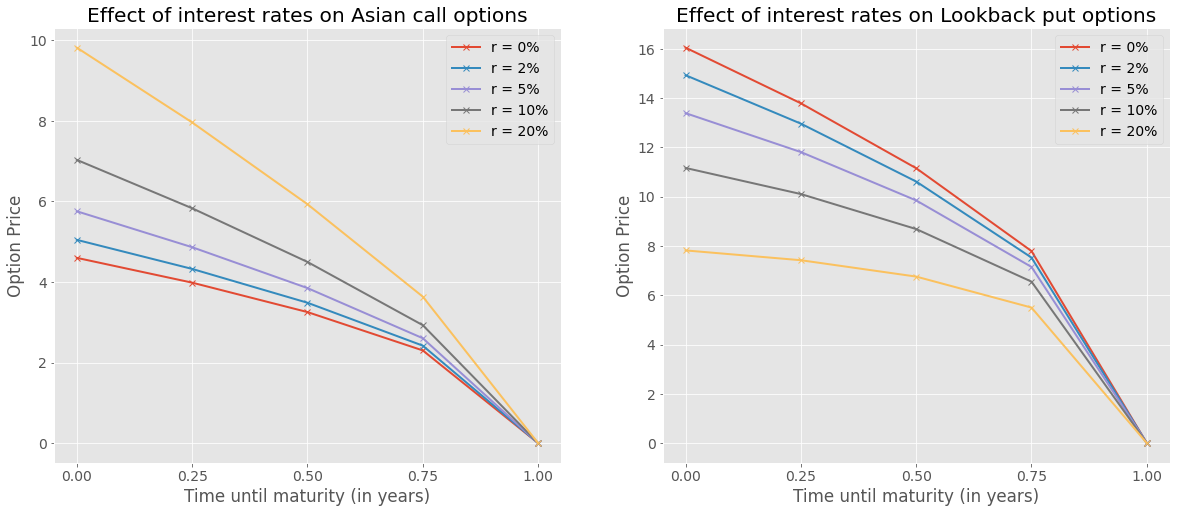

In [14]:
# Define parameters
E = 100;S0 = 100; r = 0.05; sigma = 0.2; T = 1; t = 252; n = 100000
IR = [0, 0.02, 0.05, 0.1, 0.2] # varying interest rate
times = [0, 0.25, 0.5, 0.75, 1] # option price from now until expiry
cols = ['r = 0%','r = 2%', 'r = 5%', 'r = 10%','r = 20%']

# Building the grid to store the results of the different scenarions in a dataframe
grid_asian = zeros((len(times), len(cols)))
grid_asian = pd.DataFrame(grid_asian, index=times, columns= cols)
grid_lb = zeros((len(times), len(cols)))
grid_lb = pd.DataFrame(grid_lb, index=times, columns= cols)

# Estimating prices for the Asian and Lookback option with different interest rates
for j, r in enumerate(IR):
    for i, T in enumerate(times):
        Sr = simulate_path(S0, r, sigma, T, t, n)
        # Lookback floating put option
        grid_asian.iloc[i,j] = Asian(S0,E,r,T,sigma,Sr).callAritFixMCprice
        grid_lb.iloc[i,j] = Lookback(S0,E,r,T,sigma,Sr).putFloatMCprice
# Reverse maturity in order to plot option value from now until expiration
grid_asian.set_index(1-grid_asian.index.values,inplace=True)
grid_lb.set_index(1-grid_lb.index.values,inplace=True)

fig, axes = plt.subplots(1, 2)

# Plotting effect of interest rates on Asian options
axes[0].plot(grid_asian, marker ='x') 
axes[0].set_title('Effect of interest rates on Asian call options')
axes[0].set_xticks(grid_asian.index.values)
axes[0].set_xlabel('Time until maturity (in years)')
axes[0].set_ylabel('Option Price')
axes[0].legend(grid_asian.columns)

# Plotting effect of interest rates on Lookback options
axes[1].plot(grid_lb, marker ='x') 
axes[1].set_title('Effect of interest rates on Lookback put options')
axes[1].set_xticks(grid_lb.index.values)
axes[1].set_xlabel('Time until maturity (in years)')
axes[1].set_ylabel('Option Price')
axes[1].legend(grid_lb.columns)
plt.show();

We observe that **when interest rates increase, call options gain in value while put option prices are impacted negatively**. 

**Does this make sense?**

Yes! With an increase in interest rates:
- It is much cheaper to buy a call option than it is to buy the underlying shares of the stock.Therefore, call option prices increase as rates increase, because the difference between the amount of money required to buy the stock and the amount of money required to buy the option can be invested at a higher interest rate. Hence, **call option prices are positively impacted by increasing interest rates**.
- It is the opposite situation for put options: A long put can be considered as a substitute for a short stock. Investors with a short stock position receive cash, which is invested at higher interest rate. Shorting the stock becomes more profitable than buying puts, as the former generates income and the latter does the opposite. Hence, **put option prices are negatively impacted by increasing interest rates**

## Underlying stock price

### Asian options

We illustrate the effects of changes in underlying stock price and volatility on Asian call options.

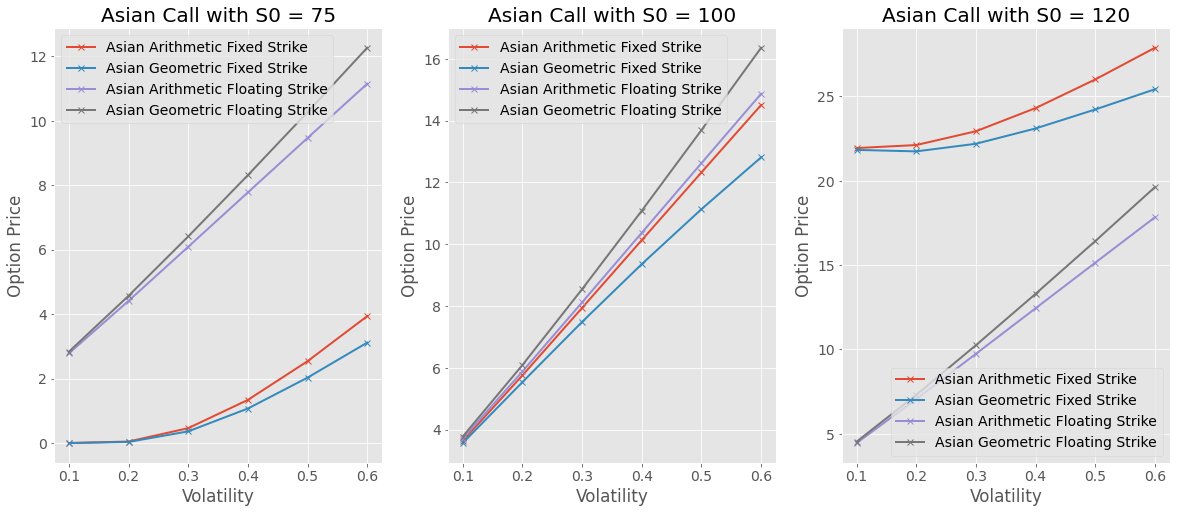

In [16]:
underlying = [75, 100, 120] # OTM, ATM and ITM situation
vols = [0.1,0.2,0.3,0.4,0.5,0.6] # constant volatility going from 10% to 60%
cols = ['Asian Arithmetic Fixed Strike', 'Asian Geometric Fixed Strike', 'Asian Arithmetic Floating Strike', 'Asian Geometric Floating Strike']

# Building the grid to store the results of the different scenarions in a dataframe
grid = zeros((len(vols), len(cols)))
grid = pd.DataFrame(grid, index=vols, columns= cols)

# Calculating Asian call prices for different spot prices, volatilities and option types
for nb, S0 in enumerate(underlying):
    for iteration, sigma in enumerate(vols):
        S = simulate_path(S0, r, sigma, T, t, n)
        # Asian Call with arithmetic fixed strike
        grid.iloc[iteration,0] = Asian(S0,E,r,T,sigma,S).callAritFixMCprice
        # Asian call option with geometric fixed strike
        grid.iloc[iteration,1] = Asian(S0,E,r,T,sigma,S).callGeomFixMCprice
        # Asian Call with arithmetic floating strike   
        grid.iloc[iteration,2] = Asian(S0,E,r,T,sigma,S).callAritFloatMCprice
        # Asian Call with geometric floating strike 
        grid.iloc[iteration,3] = Asian(S0,E,r,T,sigma,S).callGeomFloatMCprice
    
# Plotting results
    plt.subplot(1,3,nb+1)
    for col in cols:
        grid[col].plot(legend=True, marker='x')
    plt.xlabel('Volatility')
    plt.ylabel('Option Price')
    plt.title(f'Asian Call with S0 = {S0:0.0f}')
plt.show()

We observe that:
- At The Money, all Asian options behave in a similar fashion and scale linearly with volatility
- Out of The Money, Asian floating options scale linearly with volatility while Asian Fixed options have more of an exponential / quadratic shape against volatility and trade at a premium against Asian Fixed options
- In The Money, the conclusions are the same as Out of The Money, to the exception that this time, Asian floating options trade at a discount against Asian Fixed options

**Does this make sense?**

Yes! As mentioned above, Asian options generally trade at a discount in comparison to European options because the averaging component smooths the effects of volatility over the life of the options, which explains here the difference in price between Fixed and Floating options in both Out of The Money and In The Money situations: The stock price of the underlying is more volatile than its average, and the average is more volatile than the strike. Therefore, as Fixed options have a payoff which depends on the underlying stock average and a fixed strike, they are significantly less sensitive to volatility than Floating options, whose payoff depend on the underlying stock value at expiration and its average over the life of the option.
- At The Money, under low volatility regime, it is extremely likely for the average to hit the strike at maturity, considering the spot price is already close to the strike. As volatility increases, the option price increases as well, as this introduces greater potential to end up In The Money.
- Out of The Money, Asian Fixed options worth less than Asian Floating options because they have less chance to touch the strike at expiration
- In The Money, it is exactly the opposite, as Asian Fixed options have more chances to remain above the strike until maturity

### Lookback options

We now illustrate the effects of changes in underlying stock price and volatility on Lookback put options.

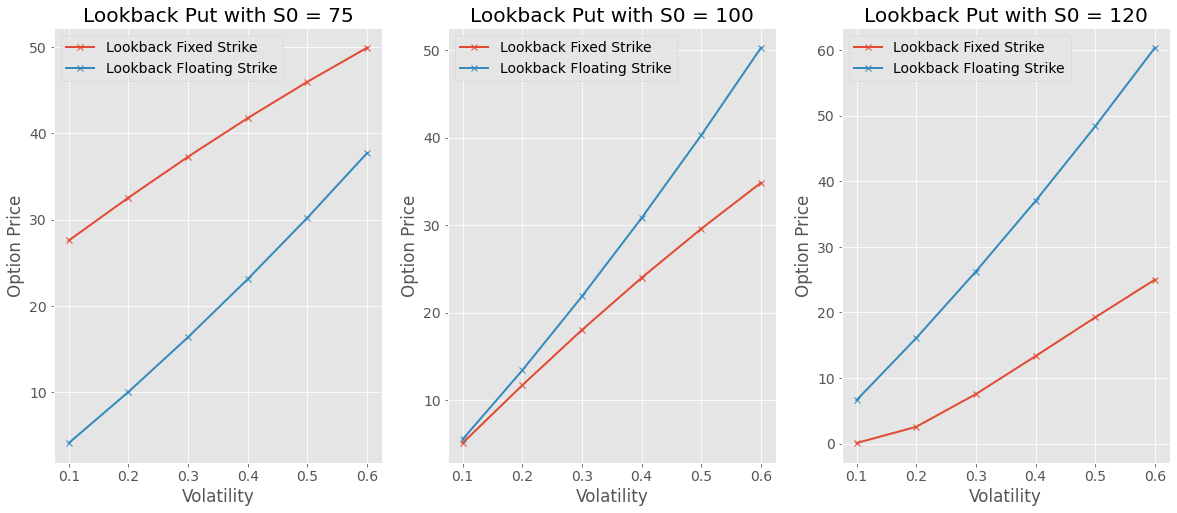

In [17]:
underlying = [75, 100, 120] # OTM, ATM and ITM situation
vols = [0.1,0.2,0.3,0.4,0.5,0.6] # constant volatility going from 10% to 60%
cols = ['Lookback Fixed Strike', 'Lookback Floating Strike']

# Building the grid to store the results of the different scenarions in a dataframe
grid = zeros((len(vols), len(cols)))
grid = pd.DataFrame(grid, index=vols, columns= cols)

# Calculating Lookback put prices for different spot prices, volatilities and option types
for nb, S0 in enumerate(underlying):
    for iteration, sigma in enumerate(vols):
        S = simulate_path(S0, r, sigma, T, t, n)
        # Lookback put option with fixed strike
        grid.iloc[iteration,0] = Lookback(S0,E,r,T,sigma,S).putFixMCprice
        # Asian call option with floating strike
        grid.iloc[iteration,1] = Lookback(S0,E,r,T,sigma,S).putFloatMCprice 
    
 # Plotting results   
    plt.subplot(1,3,nb+1)
    for col in cols:
        grid[col].plot(legend=True, marker='x')
    plt.xlabel('Volatility')
    plt.ylabel('Option Price')
    plt.title(f'Lookback Put with S0 = {S0:0.0f}')
plt.show()

As illustrated above with put options, Lookback options increase in value as volatility increase, either the option is Out of The Money, At The Money or In The Money. 

**Does this make sense?**

Yes! The higher the volatility, the higher the minimum and maximum underlying stock value, and the greater the option payoff.

### Asian, Lookback and European options looked together

Now that we have a fair understanding on how Asian and Lookback options behave under different volatility regimes, let's see how they behave together with European options. 

The chart below illustrates a geometric fixed call option, a lookback fixed call option and a European call option.

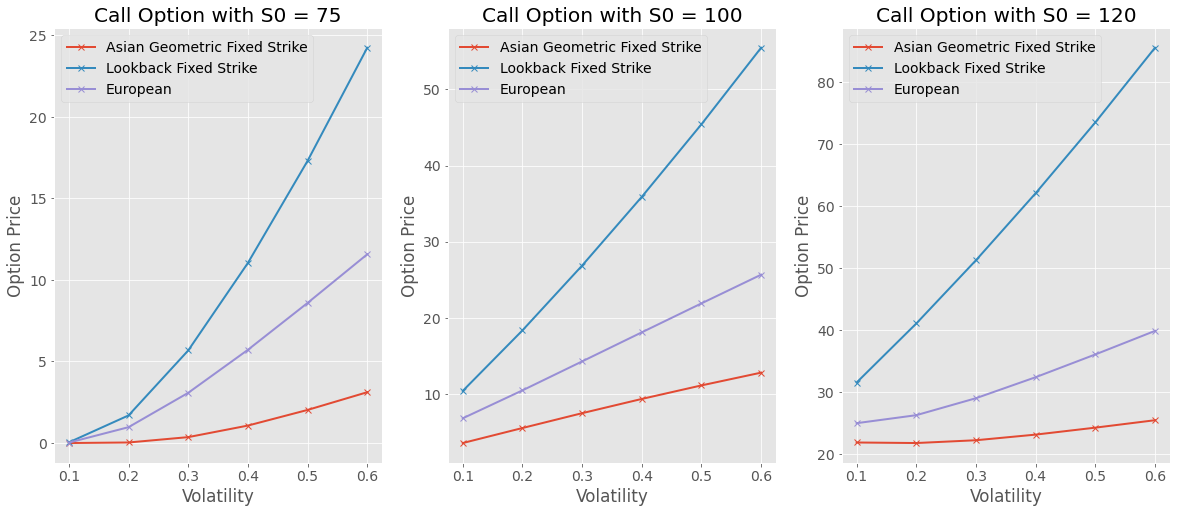

In [18]:
underlying = [75, 100, 120] # OTM, ATM and ITM situation
vols = [0.1,0.2,0.3,0.4,0.5,0.6] # constant volatility going from 10% to 60%
cols = ['Asian Geometric Fixed Strike','Lookback Fixed Strike', 'European']

# Building the grid to store the results of the different scenarions in a dataframe
grid = zeros((len(vols), len(cols)))
grid = pd.DataFrame(grid, index=vols, columns= cols)

# Calculating option call prices for different spot prices, volatilities and option types
for nb, S0 in enumerate(underlying):
    for iteration, sigma in enumerate(vols):
        S = simulate_path(S0, r, sigma, T, t, n)
        # Asian geometric call option with fixed strike
        grid.iloc[iteration,0] = Asian(S0,E,r,T,sigma,S).callGeomFixMCprice
        # Lookback call option with fixed strike
        grid.iloc[iteration,1] = Lookback(S0,E,r,T,sigma,S).callFixMCprice 
        # European call option
        grid.iloc[iteration,2] = European(S0,E,r,T,sigma,S).callMCPrice

 # Plotting results
    plt.subplot(1,3,nb+1)
    for col in cols:
        grid[col].plot(legend=True, marker='x')
    plt.xlabel('Volatility')
    plt.ylabel('Option Price')
    plt.title(f'Call Option with S0 = {S0:0.0f}')
plt.show()

**Does this make sense?**

Yes! The effect of volatility on the three options is obvious and also aligned with each option payoff:
- **Asian option mechanism smooths the effects of volatility** as the option payoffs depends of the average underlying stock price over the life of the option: in fact, an average is less exposed to sudden events in the market, and the option payoff at maturity is not lost whether the stock drops or plummets at maturity. Therefore, it is the least sensitive to volatility
- **Lookback option mechanism benefits from the effects of volatility**, as the more volatile the option is, the greater the payoff and the more likely the option ends up In The Money. Logically, its price is the highest among the three options and jumps as volatility increases. Unlike the Asian option above, the lookback option will take the most benefits of extreme events happening on financial markets.
- **European call option sits between both**. This option is not path dependent and its payoff only depends from the underlying stock price at option maturity. Therefore, its sensitivity to volatility sits between the average and min/max exotic features from Asian and Lookback options.
- **The premium factor between the three option types is substantial!** European options worth around the double of Asian option and Lookback options around 3 times!



## Strike

### Asian options

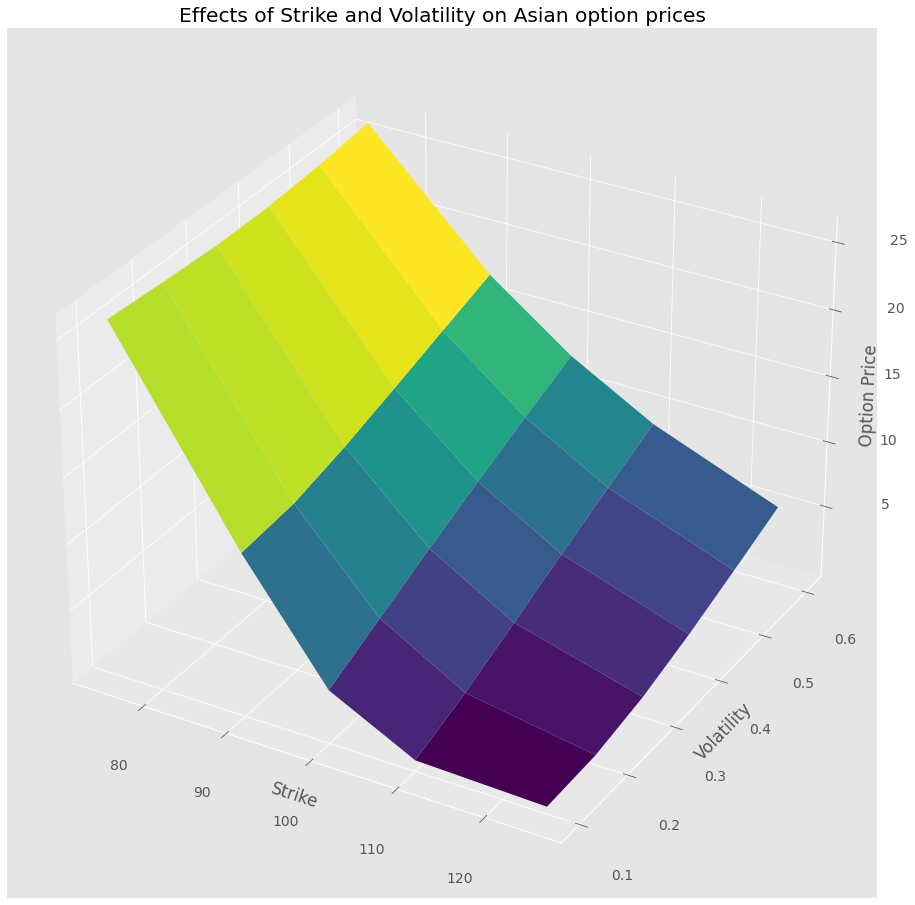

In [25]:
# Define Parameters
S0 = 100.; E= 100; r = 0.05; volatility = 0.2; T=1; t = 252; n_sims = 10000
vols = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] # From low to high volatility regime
strikes = [75, 90, 100, 110, 125] # deep OTM, OTM, ATM, ITM and deep ITM call option

# Building the grid to store the results of the different scenarions in a dataframe
grid = zeros((len(vols), len(strikes)))
grid = pd.DataFrame(grid, index=vols, columns= strikes)

# Estimating prices for the Asian option under the different strikes and volatilities
for iteration, volatility in enumerate(vols):
    for nb, E in enumerate(strikes):
        Ss = simulate_path(S0,r,volatility,T,t,n_sims)
        grid.iloc[iteration,nb] = Asian(S0,E,r,T,volatility,Ss).callGeomFixMCprice

# Building the 3D surface
X,Y = meshgrid(grid.columns,grid.index)
Z = grid
ax = plt.axes(projection='3d')
fig=ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
ax.set_title('Effects of Strike and Volatility on Asian option prices')
ax.set_xlabel('Strike')
ax.set_ylabel('Volatility')
ax.set_zlabel('Option Price')
ax.tick_params(axis='both', which='major', pad=30)
plt.show();

**Does this make sense?**

Yes!
- As volatility increases, option prices rise, as their likelihood to end up in the money at expiry increase
- As strike increases, the call option price for a call decreases as we move from an in-the-money situation (<100) to an out-the-money situation (>100). **We would observe the opposite for a put option!**

### Lookback options

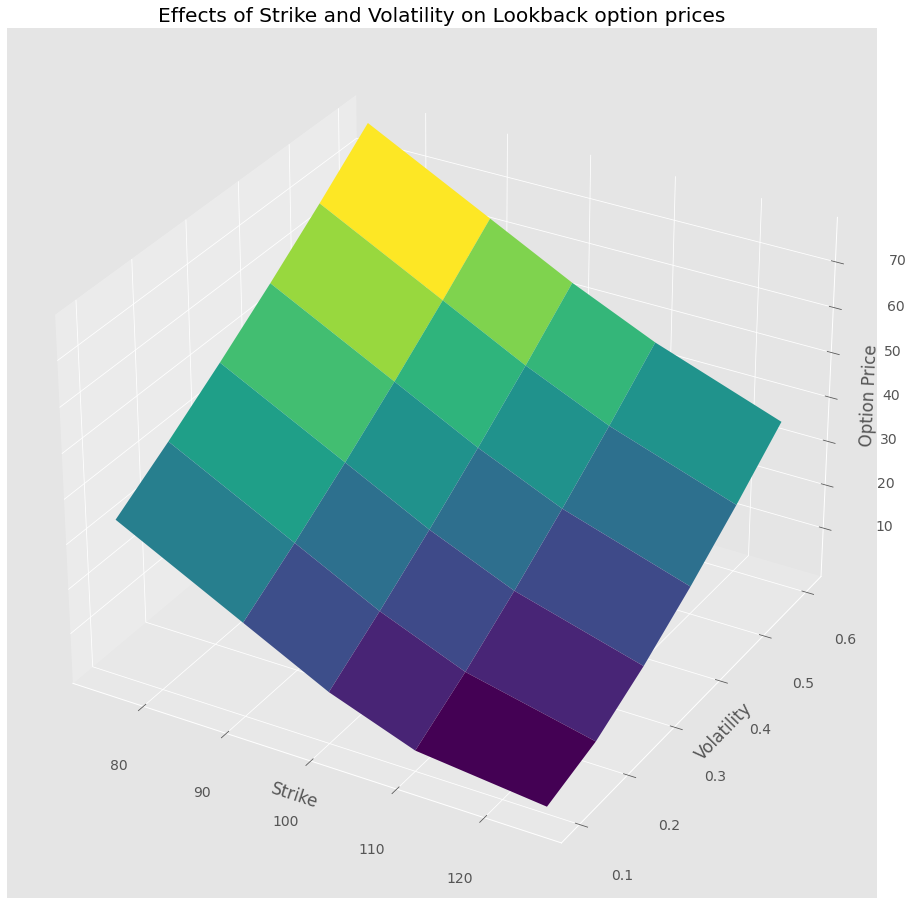

In [27]:
# Define Parameters
S0 = 100.; E= 100; r = 0.05; volatility = 0.2; T=1; t = 252; n_sims = 10000
vols = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] # From low to high volatility regime
strikes = [75, 90, 100, 110, 125] # deep OTM, OTM, ATM, ITM and deep ITM call option

# Building the grid to store the results of the different scenarions in a dataframe
grid = zeros((len(vols), len(strikes)))
grid = pd.DataFrame(grid, index=vols, columns= strikes)

# Estimating prices for the Lookback option under the different strikes and volatilities
for iteration, volatility in enumerate(vols):
    for nb, E in enumerate(strikes):
        Ss = simulate_path(S0,r,volatility,T,t,n_sims)
        grid.iloc[iteration,nb] = Lookback(S0,E,r,T,volatility,Ss).callFixMCprice

        
X,Y = meshgrid(grid.columns,grid.index)
Z = grid
ax = plt.axes(projection='3d')
plt.rcParams["figure.figsize"] = (20,16)
fig=ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Effects of Strike and Volatility on Lookback option prices')
ax.set_xlabel('Strike')
ax.set_ylabel('Volatility')
ax.set_zlabel('Option Price')
ax.tick_params(axis='both', which='major', pad=30)
plt.show();

**Does this make sense?**

Yes! Same reasons and comments as the Asian option above

## Maturity

### Asian options

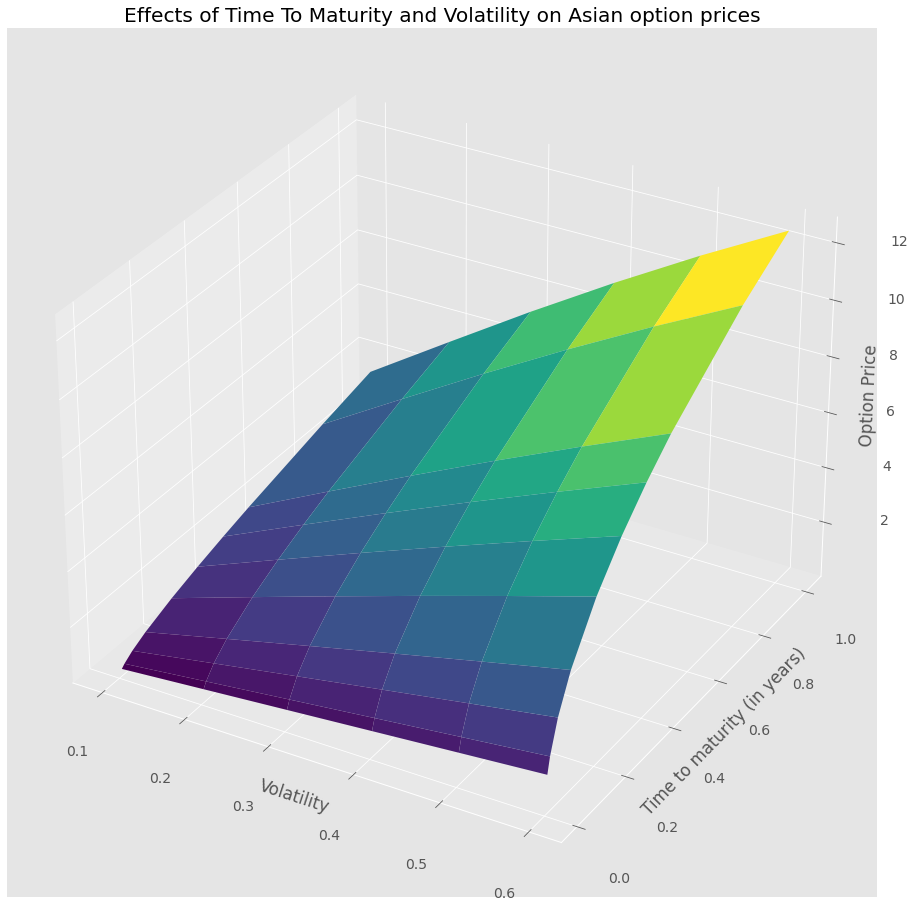

In [26]:
# Define Parameters
S0 = 100; E= 100; r = 0.05; volatility = 0.2; t = 252; n_sims = 10000
maturity = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1] # maturity close to expiry until 1 year
vols = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] # from low to high volatility regime

# Building the grid to store the results of the different scenarions in a dataframe
grid = zeros((len(maturity), len(vols)))
grid = pd.DataFrame(grid, index=maturity, columns= vols)

# Estimating prices for the Asian option under the different maturities and volatilities
for iteration, T in enumerate(maturity):
    for nb, volatility in enumerate(vols):
        Ss = simulate_path(S0,r,volatility,T,t,n_sims)
        grid.iloc[iteration,nb] = Asian(S0,E,r,T,volatility,Ss).callGeomFixMCprice

# Building the 3D surface       
X,Y = meshgrid(grid.columns,grid.index)
Z = grid
ax = plt.axes(projection='3d')
fig=ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Effects of Time To Maturity and Volatility on Asian option prices')
ax.set_xlabel('Volatility')
ax.set_ylabel('Time to maturity (in years)')
ax.set_zlabel('Option Price')
ax.tick_params(axis='both', which='major', pad=30)
plt.show();

**Does this make sense?**

Yes!
- As volatility increases, option prices rise, as their likelihood to end up in the money at expiry increase
- As maturity increases, the option price rises as it gives more time for the stock to be in the money at expiry. **This is true for both call and put Asian options!**

### Lookback options

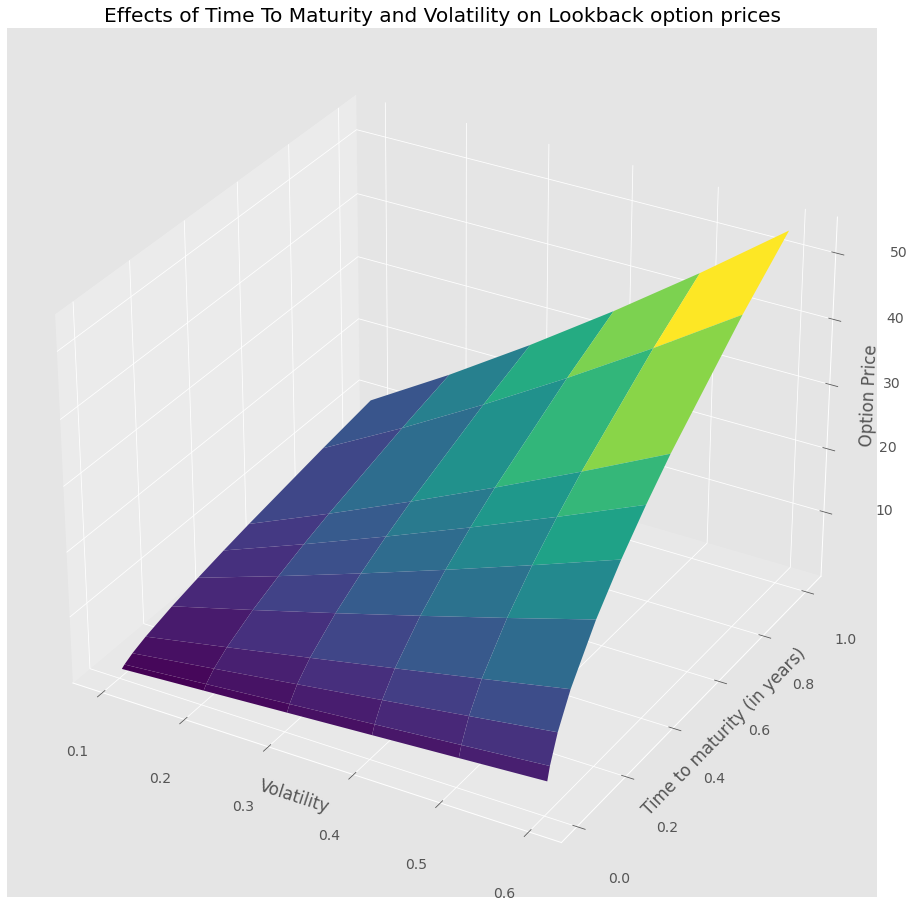

In [28]:
# Define Parameters
S0 = 100; E= 100; r = 0.05; volatility = 0.2; t = 252; n_sims = 10000
maturity = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1] # deep OTM, OTM, ATM, ITM and deep ITM call option
vols = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] # From low to high volatility regime

# Building the grid to store the results of the different scenarions in a dataframe
grid = zeros((len(maturity), len(vols)))
grid = pd.DataFrame(grid, index=maturity, columns= vols)

# Estimating prices for the Lookback option under the different maturities and volatilities
for iteration, T in enumerate(maturity):
    for nb, volatility in enumerate(vols):
        Ss = simulate_path(S0,r,volatility,T,t,n_sims)
        grid.iloc[iteration,nb] = Lookback(S0,E,r,T,volatility,Ss).callFixMCprice

# Building the 3D surface        
X,Y = meshgrid(grid.columns,grid.index)
Z = grid
ax = plt.axes(projection='3d')
fig=ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Effects of Time To Maturity and Volatility on Lookback option prices')
ax.set_xlabel('Volatility')
ax.set_ylabel('Time to maturity (in years)')
ax.set_zlabel('Option Price')
ax.tick_params(axis='both', which='major', pad=30)
plt.show();

**Does this make sense?**

Yes! Same reasons and comments as the Asian option above

## Discrete time

**Until now, we assumed continuous time**: average, minimum and maximum were computed using daily values of the underlying stock price. In this sub-section, we illustrate discrete time using monthly sampling. In practice, this means that average, minimum and maximum values of the underlying stock are no longer computed using the daily dataset when computing the option payoff $S$, but using only the first price of the month $S_{monthly}$.

In [32]:
# Use of numpy slicing start:stop:step for monthly sampling
E = 100;S0 = 100; r = 0.05; volatility = 0.2; T = 1; t = 252; n = 100000
S = simulate_path(S0,r,volatility,T,t,n)
S_monthly = S[1::20]

**Note:** There is in Python a function *' resample () '* which allows to sample weekly, monthly, etc values quite easily. However, we don't use it here as this function works with a datetime index.

Let's look on the effect of continuous VS discrete time on Asian and lookback options

### Asian options

We take the example of Asian call options

In [33]:
# Getting Asian option prices in continuous and discrete time
table = [['Asian Arithmetic Fixed Strike', Asian(S0,E,r,T,sigma,S).callAritFixMCprice, Asian(S0,E,r,T,sigma,S_monthly).callAritFixMCprice], \
         ['Asian Geometric Fixed Strike', Asian(S0,E,r,T,sigma,S).callGeomFixMCprice, Asian(S0,E,r,T,sigma,S_monthly).callGeomFixMCprice], \
         ['Asian Arithmetic Floating Strike', Asian(S0,E,r,T,sigma,S).callAritFloatMCprice, Asian(S0,E,r,T,sigma,S_monthly).callAritFloatMCprice], \
         ['Asian Geometric Floating Strike', Asian(S0,E,r,T,sigma,S).callGeomFloatMCprice, Asian(S0,E,r,T,sigma,S_monthly).callGeomFloatMCprice] ]
header = ['Call Option','Continuous time (daily)', 'Discrete time (monthly sampling)']
print(tabulate(table,headers=header))

Call Option                         Continuous time (daily)    Discrete time (monthly sampling)
--------------------------------  -------------------------  ----------------------------------
Asian Arithmetic Fixed Strike                       5.75649                             5.55733
Asian Geometric Fixed Strike                        5.53884                             5.33364
Asian Arithmetic Floating Strike                    5.88179                             5.63512
Asian Geometric Floating Strike                     6.09164                             5.85185


**Does this make sense?**

Yes! Asian options using discrete monthly sampling are naturally cheaper than continuous time options: as the average is computed on 20 times less data points, the volatility is smoothed by the average and the monthly sampling, resulting in a lower price. Also, as the averaging is done in a discrete fashion, they are less likely to end up in the money, which confirms why they trade at a discount.

Let's see in affect on discrete sampling at various time intervals: weekly, monthly and quarterly, on the Asian option price.

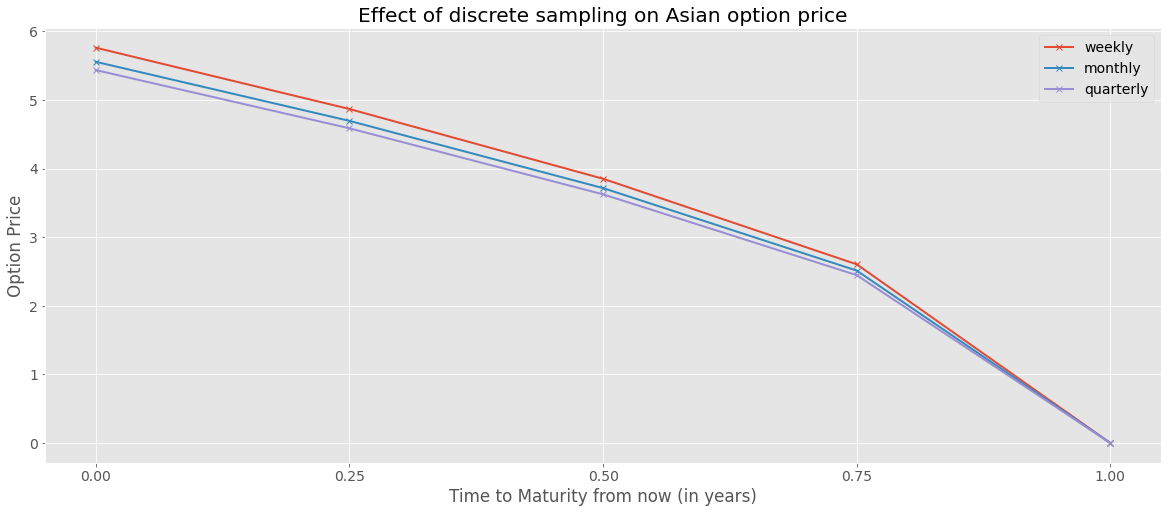

In [36]:
# Define Parameters
E = 100; S0 = 100; r = 0.05; sigma = 0.2; T = 1; t = 252; n = 100000
discrete = [5, 20, 60] # average based on weekly, monthly and quarterly stock prices
times = [0, 0.25, 0.5, 0.75, 1] # option price from now until expiry
cols = ['weekly','monthly', 'quarterly']

# Building the grid to store the results of the different scenarions in a dataframe
grid = zeros((len(times), len(cols)))
grid = pd.DataFrame(grid, index=times, columns= cols)

# Estimating prices for the Asian option with different discrete sampling
for i, T in enumerate(times):
    Sd = simulate_path(S0, r, sigma, T, t, n)
    for j, days in enumerate(discrete):
        S_discrete=Sd[1::days]
        # Asian geometric call option with fixed strike
        grid.iloc[i,j] = Asian(S0,E,r,T,sigma,S_discrete).callAritFixMCprice
# Reverse maturity in order to plot option value from now until expiration
grid.set_index(1-grid.index.values,inplace=True)
                    
# Plotting results
grid.plot(legend=True, marker='x')
plt.xticks(grid.index.values)
plt.xlabel('Time to Maturity from now (in years)')
plt.ylabel('Option Price')
plt.title('Effect of discrete sampling on Asian option price')
plt.show() 

The plot confirms our intuition. The lower the number of observations in the average, the lower the option value.

### Lookback options

In [34]:
# Getting Lookback option prices in continuous and discrete time
table = [['Fixed Lookback', Lookback(S0,E,r,T,sigma,S).callFixMCprice, Lookback(S0,E,r,T,sigma,S_monthly).callFixMCprice, \
         Lookback(S0,E,r,T,sigma,S).putFixMCprice, Lookback(S0,E,r,T,sigma,S_monthly).putFixMCprice], \
         ['Floating Lookback', Lookback(S0,E,r,T,sigma,S).callFloatMCprice, Lookback(S0,E,r,T,sigma,S_monthly).callFloatMCprice, \
         Lookback(S0,E,r,T,sigma,S).putFloatMCprice, Lookback(S0,E,r,T,sigma,S_monthly).putFloatMCprice]]
header = ['Option Price','Call, continuous time', 'Call, discrete time', \
         'Put, continuous time', 'Put, discrete time']
print(tabulate(table,headers=header))

Option Price         Call, continuous time    Call, discrete time    Put, continuous time    Put, discrete time
-----------------  -----------------------  ---------------------  ----------------------  --------------------
Fixed Lookback                     18.3544                15.4265                 11.6911               9.67348
Floating Lookback                  16.6527                14.3296                 13.3927              10.5927


**Does this make sense?**

Yes! As expected, lookback options estimated under monthly discrete time are cheaper than continuous-time options, as they benefit to a lower extent of the volatility of the underlying stock price. Also, as we now 'look-back' over fewer data points to estimate the option payoff, the volatility benefit is now diminished, which confirms why discrete Lookback options trade at a discount in comparison to their continuous counterparts.

Let's see in affect on discrete sampling at various time intervals: weekly, monthly and quarterly, on the Lookback option price.

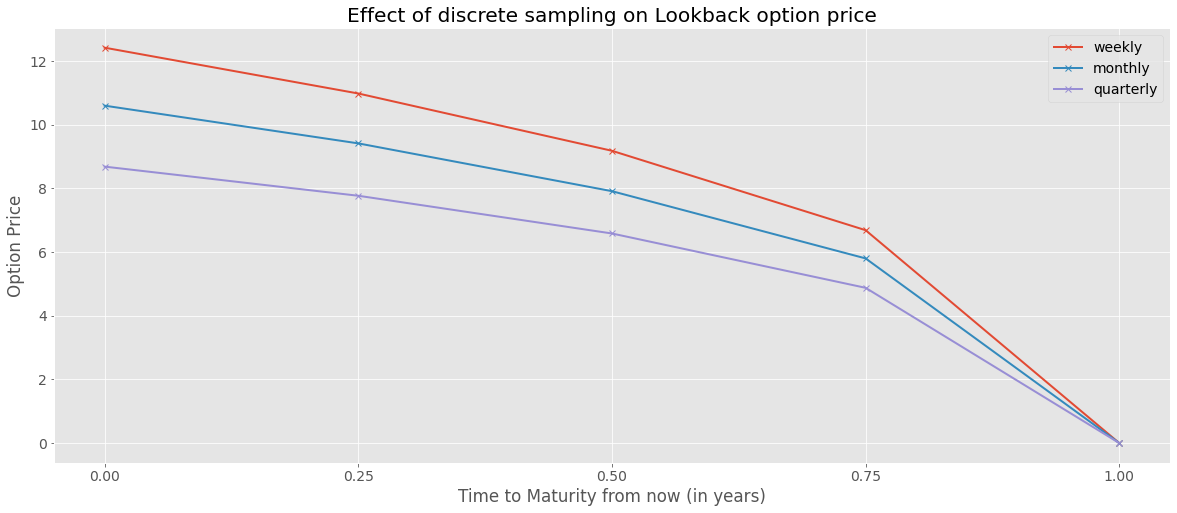

In [35]:
# Define parameters
E = 100;S0 = 100; r = 0.05; sigma = 0.2; T = 1; t = 252; n = 100000
discrete = [5, 20, 60] # average based on daily, weekly, monthly and quarterly stock prices
times = [0, 0.25, 0.5, 0.75, 1] # option price from now until expiry
cols = ['weekly','monthly', 'quarterly']

# Building the grid to store the results of the different scenarions in a dataframe
grid = zeros((len(times), len(cols)))
grid = pd.DataFrame(grid, index=times, columns= cols)

# Estimating prices for the Lookback option with different discrete sampling
for i, T in enumerate(times):
    Sd = simulate_path(S0, r, sigma, T, t, n)
    for j, days in enumerate(discrete):
        S_discrete=Sd[1::days]
        # Lookback floating put option
        grid.iloc[i,j] = Lookback(S0,E,r,T,sigma,S_discrete).putFloatMCprice
# Reverse maturity in order to plot option value from now until expiration
grid.set_index(1-grid.index.values,inplace=True)

# Plotting results 
grid.plot(legend=True, marker='x')
plt.xticks(grid.index.values)
plt.xlabel('Time to Maturity from now (in years)')
plt.ylabel('Option Price')
plt.title('Effect of discrete sampling on Lookback option price')
plt.show() 

The effect is similar for Lookback options: The less frequently we can 'look-back' to estimate the option payoff, the cheaper the option.

# Influence of parameters on the Euler-Maruyama scheme

Until now, we priced Asian and Lookback options with a Monte-Carlo approach, the underlying stock process being simulated with a Euler-Maruyama scheme. This section aims to investigate on potential solutions on **how to improve the accuracy of the option price** we got. More particularly, we will look after:
- The Milstein correction
- Antithetic variate method
- Control variate method

## Mistein correction

As we have seen in section I, the Euler-Maruyama scheme works as follows, obtained from a Taylor Series development of the solution of the Stochastic Differential Equation that rules the underlying stock price under the risk neutral probability $\mathbb{Q}$

$$S_{t+\delta t} \sim S_t \; (1 + r\delta t + \sigma \phi \sqrt{\delta t})$$

Pushing the Taylor expansion one degree further, ie in $O\,(\delta t)$, $S_{t+\delta t}$ can be written as

$$S_{t+\delta t} \sim S_t \; \left(1 + r\delta t + \sigma \phi \sqrt{\delta t}+\frac{1}{2}\sigma^2(\phi^2-1)\delta t\right)$$

The term $\frac{1}{2}(\phi^2-1)\delta t$ is called the **Milstein correction**. This correction term brings better precision when simulating the underlying stock price, and hence leads to a better approximation of the option payoff.

## Variance reduction methods

Monte Carlo methods are simulation algorithms to estimate a numerical quantity in a statistical model. The random part in the Euler-Maruyama scheme that we developed and used until now is sampled from a standard normal distribution. However, there are a few methods that provide for higher accuracy, based on variance reduction techniques. 

Unlike the Milstein function, which aims to get a better accuracy by adding an extra-term to the Euler-Maruyama scheme, the variance reduction methods aim to get a better accuracy by reducing the variance of Monte Carlo estimates. The objective of such methods is that, instead of simply enlarging the number of simulations, we focus on narrowing the confidence interval of the option price in order to reduce the variance of Monte Carlo estimates. The main interest of variance reduction techniques is to make the model more efficient without the need to increase the number of simulations.

### Antithetic variate method

In the antithetic variate method, we try to reduce the variance by introducing negative dependence between pairs of random draws (i.e. establishing an antithetic relationship between the replication pairs). Concretely, we sample from a standard normal distribution $N/\,2$ random numbers instead of $N$, we take their opposite and obtain by concatenation a set of N random numbers. 

Let's have a look on the impact of the antithetic approach versus the standard approach:

In [37]:
# For reproductability
random.seed(10)

# Generating random variables
N = 1000000
w = random.standard_normal(N)  # set of N random variables sampled from a standard normal distribution
sn = random.standard_normal(int(N/2))  # set of N/2 random variables sampled from a standard normal distribution
# Taking the opposite of each N/2 random variable obtained above and concatenate
sna = concatenate((sn,-sn), axis=0)

# Print Results
table = [['Without Antithetic Variates', w.mean(), round(w.std(),3)], ['With Antithetic Variates', sna.mean(), round(sna.std(),3)]]
header = ['Method','Mean', 'Standard Deviation']
print(tabulate(table,headers=header))

Method                               Mean    Standard Deviation
---------------------------  ------------  --------------------
Without Antithetic Variates  -0.000443247                 1
With Antithetic Variates      8.34888e-20                 0.999


We notice that the **mean is much closer to 0 when sampling from the antithetic variate method** rather than the standard one. Standard deviation are very close to 1 in both cases.

**Note**: Different methods exist to generate antithetic variates, as, for each $p$ sampled on $[0,1]$, taking the number $1-p$ instead of its opposite to build the antithetic pair.

### Control variate method

In control variates method, we exploit information about the errors in estimates of known quantities to reduce the error of an estimate of an unknown quantity.

Our goal is to estimate $E[Y]$, Y being an unknown distribution. $\hat{Y}=\frac{1}{n}\sum_{i=1}^{n} Y_i$ is an unbiased estimator. Let's use another variable $X$, namely the control variate, where $E[X]$ is known, to generate $$\bar{Y}\,(b)=\frac{1}{n}\sum_{i=1}^{n} \left(Y_i-b\,(X_i - E[X])\right)$$

$b=\frac{cov[X,Y]}{var[Y]}$ is the optimal coefficient for reducing the variance: **the higher the correlation between the control variate and the Monte Carlo estimate, the higher the variance reduction**

## Monte Carlo convergence 

The Monte Carlo approach to value options is the most popular across the financial industry. **If the Monte Carlo method has as main advantage to easily incorporate complex path dependency, its accuracy comes to the detriment of computational cost, as a large number of simulations is required to converge towards an adequate solution**.

**The role of that section is to estimate which method detailed above converges the fastest towards the Black Scholes closed form option price**. We will take the example of an Asian geometric fixed call option to illustrate the convergence, as we have a closed form solution for this type of option. We will then look at the time required to conduct the various simulations.

### Illustration with an Asian geometric call option

Unlike the arithmetic Asian option, the geometric option has a Black-Scholes closed form solution. Therefore, we can estimate analytically what is the value of the Asian option we aim to price with the Monte Carlo approach. The closed form solution of the Asian geometric option is defined as follows:

$$d_1=\frac{log(S_0/K)+(T/2)(r+\sigma^2/6)}{\sigma\sqrt{T/3}} \quad \quad d_2=d_1-\sigma\sqrt{T/3}$$

$$Call_{geom} = S_0 e^{-(r+\sigma^2/6)(T/2)}N\,(d_1) - K e^{-rT}N\,(d_2)$$

$$Put_{geom} = K e^{-rT}N\,(-d_2) + S_0 e^{-(r+\sigma^2/6)(T/2)}N\,(-d_1) $$

The closed form solution of an Asian geometric option is implemented in the Asian Python class (confer section I above, *def _GeomFixBSprice*). 

**Why do we need a closed form solution for the option?**

One of the Monte Carlo drawbacks is that the method is computationally expensive: a lot of simulations are required to arrive to a decent approximations. Therefore, we need an anchor in order to know what it the option value the Monte Carlo approach needs to converge to. This is the role of the closed form Black Scholes solution of the Asian geometric option. 

**Why monitoring the Monte Carlo convergence is important?**

As mentioned in the question above, the Monte-Carlo algorithm is computationally expensive. Therefore, the role of this section is to estimate, for each of the four methods detailed until now, which one converges the fastest towards the closed-form value. As a reminder, the four approaches that will be tested are:
- standard Euler-Maruyama
- Euler-Maruyama with Milstein correction
- Euler-Maruyama with antithetic variates method
- Euler-Maruyama with control variates method

If one method converges much faster than the others, i.e. fewer simulations are required in order to get a good estimation of the option price, then this method will be the best candidate to estimate option prices where we have no closed-form solution, as for Arithmetic Asian options for instance.

### Implementation

Let's resume how we implement the three additional methods to test the Monte-Carlo convergence:
1. Implementing the Milstein correction is trivial, as it only requires to add the correction term when simulating the underlying asset path to get an increased degree of accuracy (Taylor approximation $\sim\;O(\delta t)$ instead of $(\sqrt{\delta t})$ in the standard Euler-Maruyama scheme.
2. Implementing the antithetic variates method is also trivial, as we simply need to generate $N/2$ random numbers, take their opposite and then sample from the concatenated set.
3. The control variates method is the most sophisticated. For the control variates method to work, we must , in order to estimate our unknown variable $Y$, find another option $X$ where we know its closed form solution (i.e $E[X]$). The higher the variance between the control variate and the Monte Carlo estimate, the higher the variance reduction.

Hence, in our case:
- $Y$: Asian geometric call option price obtained with Monte Carlo approach
- $X$: European call option price obtained with Monte Carlo approach
- $E[X]$: European call option price obtained with Black Scholes closed form formula

We the price of a European option as the X variable to serve as the proxy to value the geometric Asian option Y, as we know $E[X]$ for the European option.

**Note**: As we have a closed form solution for the Asian geometric option, the control variate method that we conduct is to illustrate the convergence of the method towards the closed-form solution. If this method proves the fatest convergence towards the closed-form solution price, we can then use it to estimate option prices which have no closed-form solution, as Arithmetic Asian options.

In [121]:
def simulatepath(spot, rate, volatility, expiry, timesteps, n_sims, method):
    
    # Set the random seed for reproducibility
    random.seed(10)

    # Define dt: length of time interval 
    dt = expiry/timesteps  
    
    # Simulating 'n_sims' asset price paths with 't' timesteps
    S = zeros((timesteps, n_sims))
    S[0] = S0
    
    if method == 'Standard':
        for i in range(0, timesteps-1):
            w = random.standard_normal(n_sims)
            S[i+1] = S[i] * (1 + rate * dt + volatility * sqrt(dt) * w)
        return S
    
    if method == 'Milstein':
        for i in range(0, timesteps-1):
            w = random.standard_normal(n_sims)
            S[i+1] = S[i] * (1 + rate * dt + volatility * sqrt(dt) * w + 1/2 * volatility**2 * (w**2-1) * dt)
        return S

    if method == 'Antithetic':
        for i in range(0, timesteps-1):
            sn = random.standard_normal(int(n_sims/2))
            sna = concatenate((sn,-sn), axis=0)
            S[i+1] = S[i] * (1 + rate * dt + volatility * sqrt(dt) * sna) 
        return S
    
    else:
        raise Exception('Please use one of the three methods: Standard, Milstein or Antithetic')

In [136]:
def controlvariates(EU_MC, AsianGeom_MC, EU_BS):
        c = cov(EU_MC,AsianGeom_MC)[0,1]/var(EU_MC)
        AsianGeom_CV = AsianGeom_MC - c*(EU_MC - EU_BS)
        return AsianGeom_CV

We now have all we need to run the Monte Carlo convergence analysis

Method              Elapsed time
------------------  --------------
Standard            0:00:00.025898
Milstein            0:00:00.025897
Antithetic variate  0:00:00.013997
Control variate     0:00:00.026895


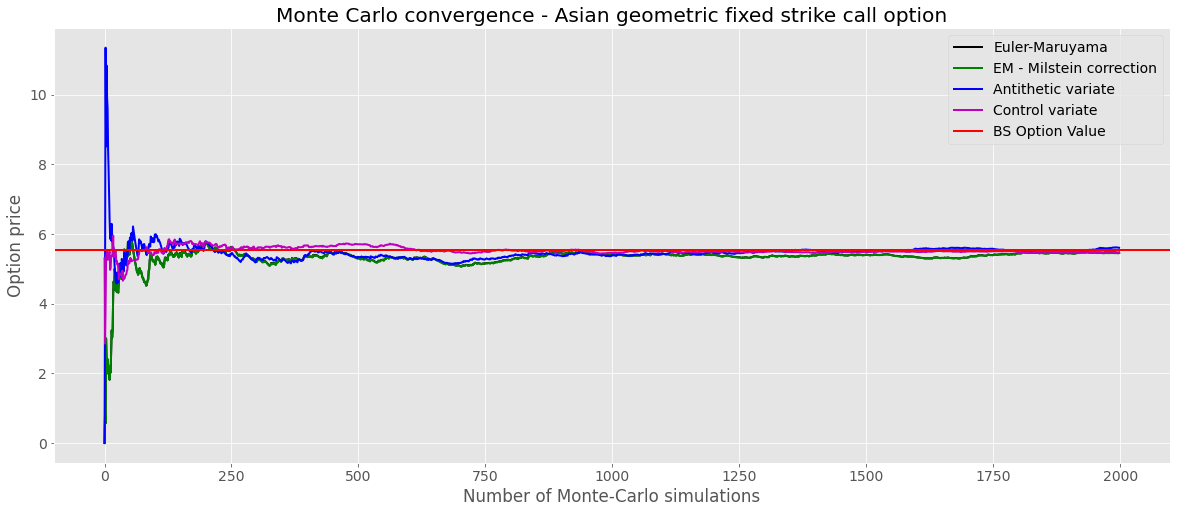

In [123]:
# Define parameters
S0 = 100.; E = 100. ; r = 0.05; sigma = 0.2; T = 1; t = 252; N = 2000
MC = []; MC_m = []; MC_EU = []; MC_a = []; MC_cv = []

# Call the simulation function for each of the method
start = datetime.now()
S_MC = simulatepath(S0, r, sigma, T, t, N, 'Standard')
end = datetime.now()
start_m = datetime.now()
S_MC_m = simulatepath(S0, r, sigma, T, t, N, 'Milstein')
end_m = datetime.now()
start_a = datetime.now()
S_MC_a = simulatepath(S0, r, sigma, T, t, N, 'Antithetic')
end_a = datetime.now()

# Recalculating the Asian geometric call prices 
MC = [exp(-r*T) * maximum(g_mean(S_MC)-E,0)[:n].mean(axis=0) for n in range(1,N)]
MC_m = [exp(-r*T) * maximum(g_mean(S_MC_m)-E,0)[:n].mean(axis=0) for n in range(1,N)]
MC_a = [exp(-r*T) * maximum(g_mean(S_MC_a)-E,0)[:n].mean(axis=0) for n in range(1,N)]

# Control variate method calculation (MC and BS European call values required as explained above)
MC_EU = [exp(-r*T) * maximum(S_MC[-1]-E,0)[:n].mean(axis=0) for n in range(1,N)]
start_cv = datetime.now()
MC_cv = controlvariates(MC_EU,MC,European(100,100.,0.05,1,0.2,S_MC[-1]).callBSPrice)
end_cv = datetime.now()

# Print Results
table = [['Standard', end - start], ['Milstein',end_m - start_m], ['Antithetic variate',end_a - start_a], \
        ['Control variate', (end - start) + (end_cv - start_cv)]]
header = ['Method', 'Elapsed time']
print(tabulate(table,headers=header))

plt.plot(MC, c='k', label = 'Euler-Maruyama')
plt.plot(MC_m, c='g', label = 'EM - Milstein correction')
plt.plot(MC_a, c='b', label = 'Antithetic variate')
plt.plot(MC_cv, c='m', label = 'Control variate')
plt.axhline(Asian(S0,E,r,T,sigma,S).callGeomFixBSprice, c='r', label='BS option price')
plt.legend(loc='upper right')
plt.xlabel('Number of Monte-Carlo simulations')
plt.ylabel('Option price')
plt.title('Monte Carlo convergence - Asian geometric fixed strike call option');

In conclusion: 
- **The control variate method proves to be the most robust approach, as it rapidly converges to the option closed-form solution**, in approximately 250 Monte Carlo simulations.
- The antithetic variate method is the next approach to converge towards the option closed-form solution. More simulations (approximately 1,000) are however required to reach convergence in comparison to the control variate approach.
- The Milstein approach doesn't add much precision when estimating the option price in comparison to the standard Euler-Maruyama scheme, as both curves are superposed in the chart. These two approaches are the slowest to converge towards the closed-form option price.

### Standard Error

For a number of $N$ Monte Carlo simulations, we define Monte Carlo error to be the standard deviation of the Monte Carlo estimator $\hat{S}_N$, which is the average of the $N^{th}$ individual path of the underlying stock price. The standard error is commonly define as $$\epsilon_N=\frac{\sigma_{\hat{S}_N}}{\sqrt{N}}$$

The plot below illustrates the evolution of the Standard Error for the four different techniques we test as the number of Monte Carlo simulations increase.

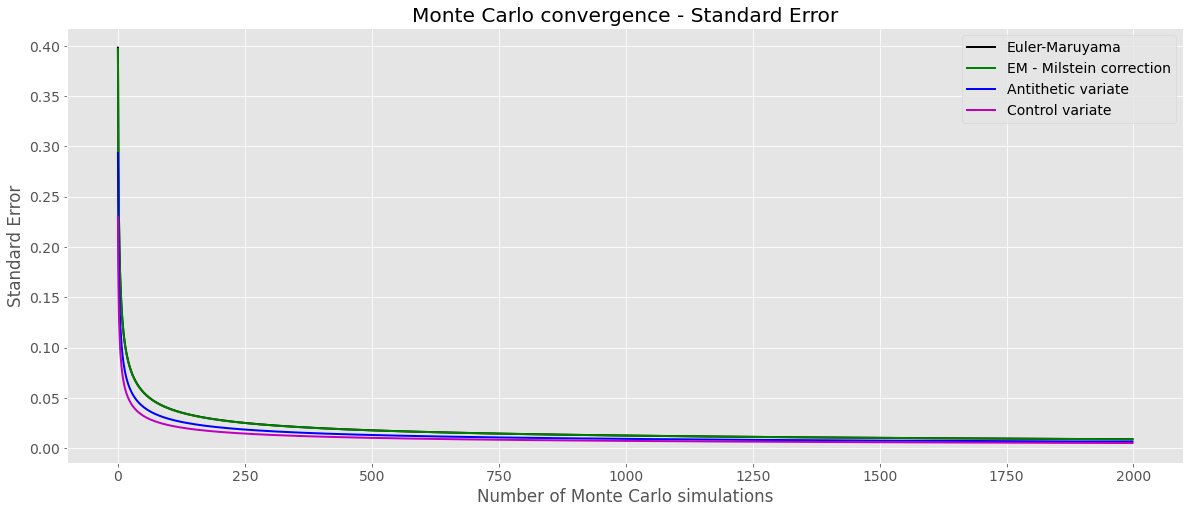

In [115]:
# Defining standard errors
varMC = [sqrt(var(MC)/n) for n in range(1,N)]
varMC_m = [sqrt(var(MC_m)/n) for n in range(1,N)]
varMC_a = [sqrt(var(MC_a)/n) for n in range(1,N)]
varMC_cv = [sqrt(var(MC_cv)/n) for n in range(1,N)]

plt.plot(varMC, c='k', label = 'Euler-Maruyama')
plt.plot(varMC_m, c='g', label = 'EM - Milstein correction')
plt.plot(varMC_a, c='b', label = 'Antithetic variate')
plt.plot(varMC_cv, c='m', label = 'Control variate')
plt.legend(loc='upper right')
plt.xlabel('Number of Monte Carlo simulations')
plt.ylabel('Standard Error')
plt.title('Monte Carlo convergence - Standard Error');

The control variate method is the fastest to converge towards the lowest error resulting of the Monte Carlo simulation, followed by the antithetic variate and Milstein / Standard Euler-Maruyama method.

In conclusion:
- **The control variate method gives the best estimation of option prices in the least number of simulations!**
- **Monte-Carlo methods can be computationally expensive without variance reduction methods**. As an example, the control variate method converges 5 times faster than the standard Euler-Maruyama scheme
- **The Standard Error resulting of the control variate method decreases the fastest, confirming that this approach is the most robust of the four techniques we went through in Section III.** Anyone keen to have accuracy in a Monte Carlo approach under the least amount of simulations required should definitely consider the control variate method!

# References

**CQF lectures and tutorials**
1. CQF Module 3 Lecture 4: Introduction to Numerical methods
2. CQF Module 3 Lecture 5: Exotic Options
3. CQF Module 3 Lecture 6: Further Numerical Methods
4. CQF Module 3 Tutorial 1: Monte Carlo techniques

**CQF Python classes**
1. CQF Python primers
2. CQF Python lab: Black Scholes option pricing
3. CQF Python lab: Monte Carlo simulation

**Books**
1. Paul Wilmott on Quantitative Finance, second edition
2. Paul Wilmott introduces Quantitative Finance, second edition
3. Monte Carlo methods in finance, Peter Jäckel

**External articles**
1. Numerical Algorithm for Delta of Asian Option, Wang, Zhang, Yu, 2015
2. Asian Option Pricing and Volatility, Erik Wiklund
3. Sub-Replication and Replenishing Premium: Efficient Pricing of Multi-State Lookbacks, Wong, Kwok, 2003